# Assignment

How can we use Bayesian models to compare two distributions? It turns out that we can compare Bayesian models in several ways. In this assignment, we will compute and compare credible intervals of the posterior distribution of a model parameter.

Before we begin, let's load the libraries and functions we need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import itertools
import warnings
sns.set(rc = {'figure.figsize': (10, 8)})

In [2]:
def plot_pp(x, p, l, pp):
    sns.lineplot(x, l, color = 'lightgrey', linewidth = 10)
    sns.lineplot(x, p, color = 'blue', linewidth = 2)
    sns.lineplot(x, pp, color = 'red', linewidth = 2)
    plt.xlabel('p')
    plt.ylabel('PDF of p')
    plt.title('Prior, likelihood and posterior distributions')
    plt.legend(labels = ['likelihood', 'prior', 'posterior'])
    return None

In [3]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(p, post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))


For this example, we will compare the posterior distribution of the heights of sons to the heights of the mothers in the Galton family dataset. As a first step, we will compute and evaluate Bayesian models for the mean heights using a subset of just 25 observations. 

In [4]:
families = pd.read_csv('./GaltonFamilies.csv', index_col = 0)
families

,father,mother,midparentHeight,children,childNum,gender,childHeight
family,,,,,,,
001,78.5,67.0,75.43,4,1,male,73.2
001,78.5,67.0,75.43,4,2,female,69.2
001,78.5,67.0,75.43,4,3,female,69.0
001,78.5,67.0,75.43,4,4,female,69.0
002,75.5,66.5,73.66,4,1,male,73.5
...,...,...,...,...,...,...,...
203,62.0,66.0,66.64,3,1,male,64.0
203,62.0,66.0,66.64,3,2,female,62.0
203,62.0,66.0,66.64,3,3,female,61.0


- Plot the distributions of the height of mothers and sons for a sample of size 25. Do the distributions appear to be significantly different? <span style="color:red" float:right>[5 point]</span>

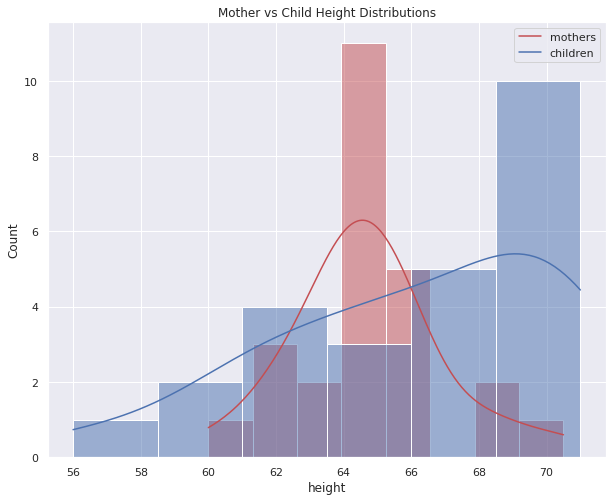

In [5]:
num_samples = 25
sample = families.sample(n=num_samples)

sns.histplot(sample['mother'], kde=True, color='r')
sns.histplot(sample['childHeight'], kde=True)
plt.xlabel('height')
plt.title('Mother vs Child Height Distributions')
plt.legend(labels=['mothers', 'children']);

I have ran the above cell several times and overall I would say the distributions are usually significant with a difference in mean height of about 4 or 5 inches. However since this is a sample, we could also get two very similar distributions on any given running of the cell.

To perform this analysis, we need to select a prior distribution, which is easy, and to compute the likelihood, which is not as easy. So first, let's see how we can get the likelihood.

For this data, we will use a normal likelihood. For something like heights, using the normal distribution makes sense. For any individual sample $X$ if it follows the normal distribution with mean $\mu$ and standard deviation $\sigma$, then it probability density function is given by

$$X \sim N(\mu, \sigma) \Rightarrow P(X | \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Bigg[ -\frac{1}{2}\big(\frac{X - \mu}{\sigma}\big)^2\Bigg]$$

For a sample ${X_1, X_2, \cdots, X_n}$ of $n$ independent normally distributed observations has the following likelihood:

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) = \prod_{i = 1}^n P(X_i | \mu, \sigma) = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Bigg[ -\frac{1}{2}\big(\frac{X_i - \mu}{\sigma}\big)^2\Bigg]$$

Notice that we multiply the individual the probabilities to get the likelihood. We can do this because we assume that the data points are independent. This seems like a relatively safe assumption. 

Now let's simplify the above equation. We can simplify things by ignoring the terms outside the exponential, since they don't depend on the sample, and replacing $=$ (is equal to) with $\propto$ (is proportional to):

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) \propto \prod_{i = 1}^n \exp \Bigg[ -\frac{1}{2}\big(\frac{X_i - \mu}{\sigma}\big)^2\Bigg]$$

Moreover, we can rely on the property $e^a e^b = e^{a + b}$ to rewrite the right-hand side as

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) \propto \exp \Bigg[ -\frac{1}{2} \sum_{i = 1}^n \big(\frac{X_i - \mu}{\sigma}\big)^2\Bigg]$$

Finally, letting $\bar X = \frac{1}{n}\sum_{i=1}^n X_i$ we can rewrite $X_i - \mu$ as $X_i - \bar X + \bar X - \mu$ and after some rearranging we get this:

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) \propto \exp \Bigg[ -\frac{1}{2 \sigma^2}  \Bigg( \sum_{i = 1}^n (X_i - \bar{X})^2 + n(\bar{X} - \mu)^2 \Bigg) \Bigg]$$

To simplify the computations here, we will only estimate the posterior distribution of $\mu$. We will use a fixed empirical estimate of the standard deviation. A more complete analysis will also estimate the posterior distribution of $\sigma$.

- Now your task is to write a function called `likelihood` that computes the likelihood as given by the above equation. The input of the function is `mu` (the parameter) and `x` (the data) and its output is the likelihood of the data given the parameter. You may find it helpful to use `np.exp` and `np.sum`. <span style="color:red" float:right>[10 point]</span>

In [6]:
def likelihood(mu, x): 
    # oh parentheses...
    l = np.exp((-1 / (2 * np.var(x))) * (np.sum(np.square(x - np.mean(x))) + len(x) * np.square(np.mean(x) - mu)))
    return l / l.sum()

Now for the prior distribution, we will use a normal distribution centered at 70 with standard deviation 1. The code for the prior is already written. Examine it and make sure you understand each step.

In [7]:
# prior distribution, normal center at 70, std=1

N = 10000
mu = np.linspace(60, 80, num = N)
prior_center = 70
prior = scipy.stats.norm.pdf(mu, loc = prior_center, scale = 1)
prior = prior / prior.sum() # normalize

Now we're ready to compute the posterior for both mother and son.

- Compute the posterior distribution for the sons (the column name is `childHeight`). You will need to compute the likelihood first. Then plot the prior, posterior and likelihood just like we did in class. <span style="color:red" float:right>[10 point]</span>

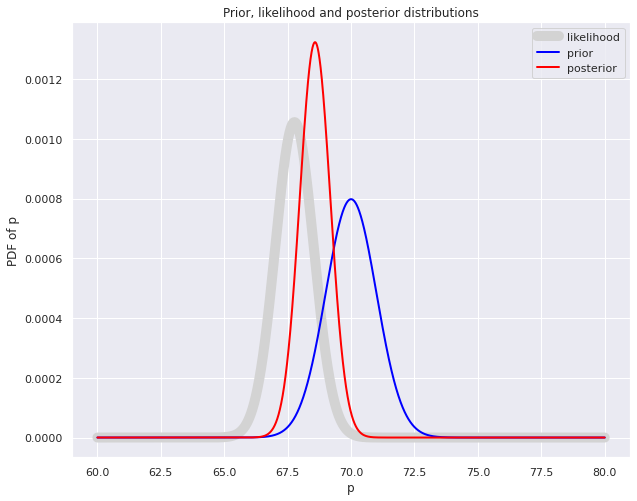

In [8]:
warnings.filterwarnings("ignore")
sons_height = families['childHeight']
sons_height_sample = sons_height.sample(25)
sons_like = likelihood(mu, sons_height_sample)
sons_post_dist = posterior(prior, sons_like)

plot_pp(mu, prior, sons_like, sons_post_dist)

- Compute the posterior distribution for mothers (the column name is `mother`). You will need to compute the likelihood first. Sons and mothers both use the same proir. Then plot the prior, posterior and likelihood just like we did in class. <span style="color:red" float:right>[5 point]</span>

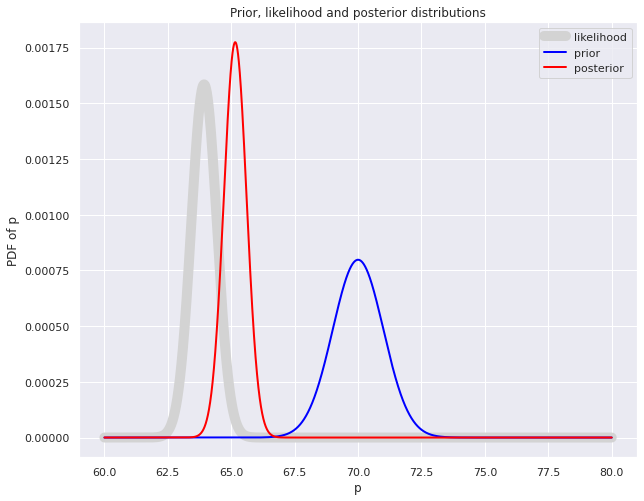

In [9]:
moms_height = families['mother']
moms_height_sample = moms_height.sample(25)
moms_like = likelihood(mu, moms_height_sample)
moms_post_dist = posterior(prior, moms_like)

plot_pp(mu, prior, moms_like, moms_post_dist)

To compare the posterior distributions of the mean heights of the sons to the distribution of the mean heights of the mothers, we compute and compare the confidence intervals. 

- Use the `plot_ci` function to plot credible intervals for mother and son heights. You can call the function twice in the same cell and the two distributions will be plotted next to each other in one plot. What conclusion do you draw about the heights of mothers versus sons? <span style="color:red" float:right>[10 point]</span>

The 0.950 credible interval is 0.025 to 0.975
The 0.950 credible interval is 0.025 to 0.975


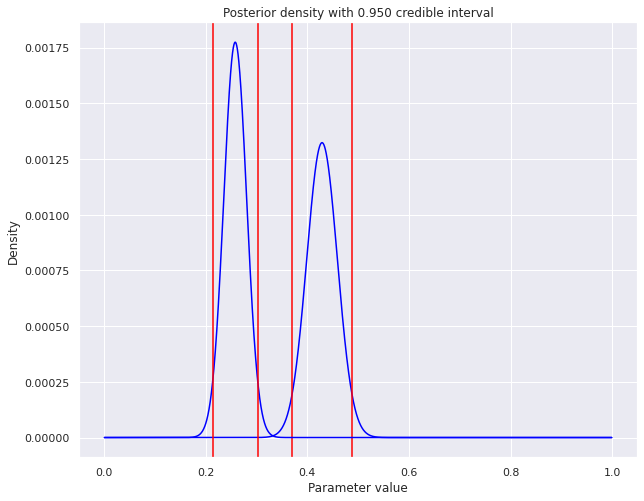

In [10]:
num_samples = 100000
x = np.linspace(.001, .999, num = 10000)

plot_ci(x, sons_post_dist, num_samples=num_samples, lower_q=lower_q, upper_q=upper_q)
plot_ci(x, moms_post_dist, num_samples=num_samples, lower_q=lower_q, upper_q=upper_q)
warnings.filterwarnings("default")

It's reassuring to see that the sons confidence inntervals don't overlap with the mothers, signifying that the sons group is significantly taller than the moms group (as one might expect).

Since the CIs don't even overlap, it can follow that the sons were significantly taller than their mothers.

# End of assignment